In [73]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import matplotlib.ticker as ticker
torch.manual_seed(125)

## Generate training data

In [74]:
# Random seed for Torch and NumPy
seed = 123
torch.manual_seed(seed)
np.random.seed(seed)

def sin(x):
    """
    sin function that works with both PyTorch tensors and NumPy arrays.
    """
    if isinstance(x, torch.Tensor): 
        return torch.sin(x)
    else:
        return np.sin(x)

def exp(x):
    """
    exponential function that works with both PyTorch tensors and NumPy arrays.
    """
    if isinstance(x, torch.Tensor): 
        return torch.exp(x)
    else:
        return np.exp(x)

# Creates used directories if they do not exist.
from pathlib import Path
directories = ["gifs", "PINN_plots", "plots"]
for d in directories:
    plots_dir = Path(d)
    plots_dir.mkdir(exist_ok=True)
    print(f"Directory '{plots_dir}' is present. ✅")

Directory 'gifs' is present. ✅
Directory 'PINN_plots' is present. ✅
Directory 'plots' is present. ✅


In [75]:
# Parameters and initial conditions
X0 = [1, 0]
w0 = 2*np.pi
b  = 2

# time domain
ti, tf = 0, 3
N  = 10_000

t = torch.linspace(ti, tf, N).view(-1,1)

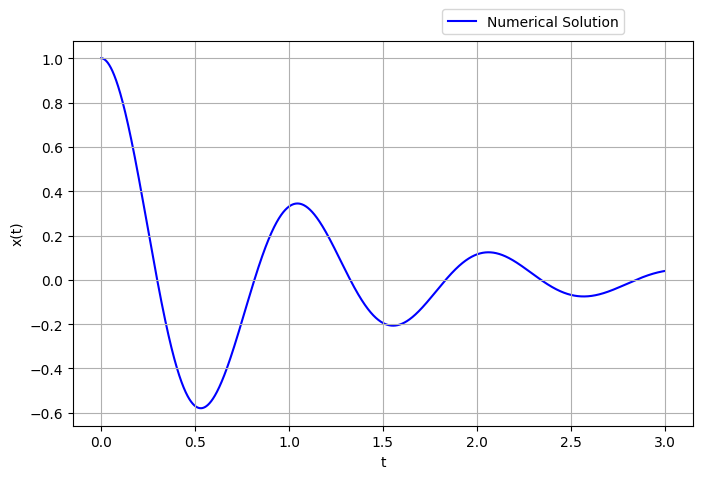

In [76]:
# Numerical solution of the ODE

# Define ODE
def F(u, v, t, params):
    """
    Defines the second order ODE: u'' = F(u, v, t)
    where the solution function is u(t) and its derivative is v(t).
    """
    w0 = params[0]
    b  = params[1]
    return -w0**2*sin(u) - b*v

# Numerical Solution
def ODE(X, t):
    dXdt = [X[1], F(X[0], X[1], t, (w0, b))]
    return dXdt

solution = torch.from_numpy(odeint(ODE, X0, t.numpy().flatten())).view(-1,2)
x1       = solution[:,0]
x2       = solution[:,1]
x1_max   = torch.abs(x1).max().item()
x2_max   = torch.abs(x2).max().item()

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(t, x1, label='Numerical Solution', color='blue', zorder=1)
ax.set_xlabel('t')
ax.set_ylabel('x(t)')
plt.legend(ncol=3, bbox_to_anchor=(0.9, 1.1))
plt.grid()
plt.show()

## PINN

In [77]:
def plot_result():
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
    
    axes[0].grid()
    axes[0].plot(t, x1, color="gray", linewidth=2, alpha=1,linestyle='--',label="Exact solution", zorder=0)
    axes[0].plot(t, p, color="blue", linewidth=2, alpha=0.8, label="PINN prediction", zorder=1)
    axes[0].scatter(t_data, x1_data, s=15, color="red", alpha=0.4, label='Training data', zorder=2)
    axes[0].scatter(t_physics.detach(), -0*torch.ones_like(t_physics.detach()), s=10, color="green", alpha=0.4,label='Collocation points', zorder=2)
    axes[0].set_ylim(-1.05*x1_max, 1.05*x1_max)
    axes[0].set_ylabel('x(t)',fontsize="x-large")
    axes[0].set_xlabel('t',fontsize="x-large")
    axes[0].legend()
    
    axes[1].grid()
    axes[1].plot(training_loss_history, label='Training Loss', color='red', linewidth=2, zorder=1)
    axes[1].plot(validation_loss_history, label='Validation Loss', color='blue', linewidth=1.5, zorder=2, alpha=0.6)
    axes[1].set_yscale('log')
    axes[1].set_xlim(0, epochs)
    axes[1].set_ylim(1e-7, 1e2)
    axes[1].set_xlabel('Epochs', fontsize="x-large")
    axes[1].set_ylabel('Loss', fontsize="x-large")
    axes[1].set_title(f'Validation loss = {validation_loss_history[-1]:.3e}', fontsize="x-large")
    axes[1].legend()
    
    fig.suptitle(f"Epoch {i}", fontsize="x-large")

    plt.tight_layout()
    plt.axis("on")

In [78]:
# Define Neural Network Structure

class FCN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        
        self.scale = lambda t: (t - ti)/(tf - ti)
        self.fcs   = nn.Sequential(*[nn.Linear(N_INPUT, N_HIDDEN),activation()])
        self.fch   = nn.Sequential(*[nn.Sequential(*[nn.Linear(N_HIDDEN, N_HIDDEN), activation()]) for _ in range(N_LAYERS-1)])
        self.fce   = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.scale(x)
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [79]:
learning_rate = 1e-3
gamma         = 0.85
epochs        = 20_000 + 1
weights = [w_data, w_derivative, w_ode] = [1e0, 1e0, 1e-2]

N_training   = 20
N_validation = 200
N_phys       = 200

N_layers = 3
N_nodes  = 32

In [80]:
# Find the points for training, validaiton, and physics loss

# Pick points for training
t_data     = torch.linspace(ti, 0.4*tf, N_training).view(-1,1)
training_data = solution[torch.searchsorted(t.flatten(), t_data.flatten()), :]
x1_data       = training_data[:,0].view(-1,1)
x2_data       = training_data[:,1].view(-1,1)

# Pick a few points for validation
t_val        = torch.linspace(ti*1.1, tf, N_validation).view(-1,1)
validation_data = solution[torch.searchsorted(t.flatten(), t_val.flatten()), :]
x1_val          = validation_data[:,0].view(-1,1)
x2_val          = validation_data[:,1].view(-1,1)


# Define the samle locations for training data
t_training  = t_data.clone().requires_grad_(True)

# Define the sample locations for validation
t_validation = t_val.clone().requires_grad_(True)

# Define the sample locations for the ODE loss
t_physics    = torch.linspace(ti, tf, N_phys).view(-1,1).requires_grad_(True)

Epoch 0: Validation Loss = 9.07262e-02, Learning rate = 8.5000e-04


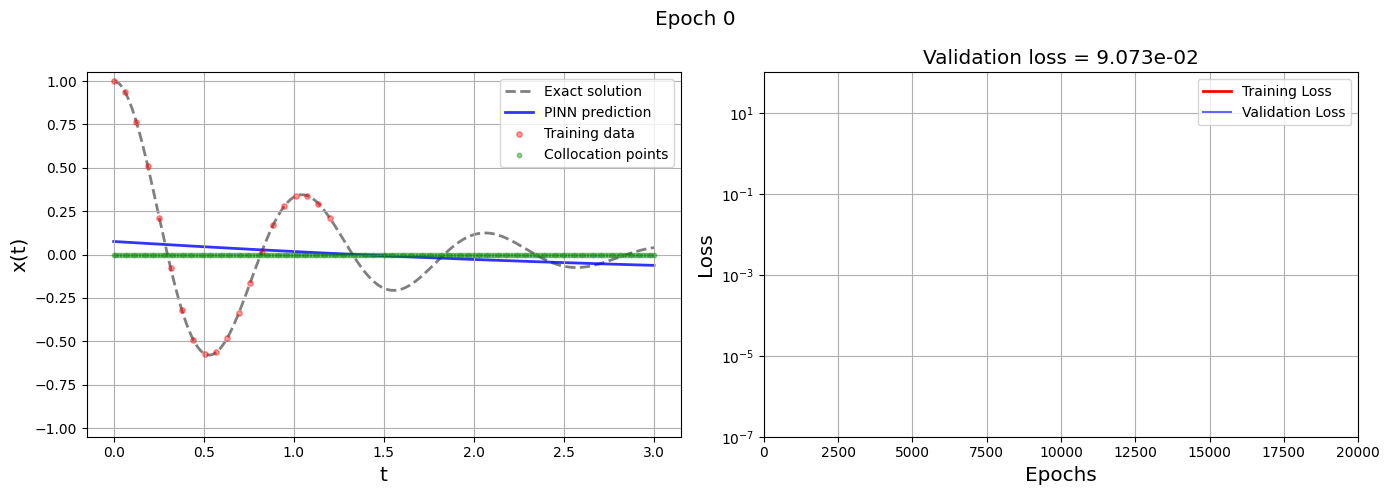

Epoch 100: Validation Loss = 7.67535e-02, Learning rate = 8.5000e-04
Epoch 200: Validation Loss = 1.36644e-02, Learning rate = 8.5000e-04
Epoch 300: Validation Loss = 5.67655e-03, Learning rate = 8.5000e-04
Epoch 400: Validation Loss = 4.57703e-03, Learning rate = 8.5000e-04
Epoch 500: Validation Loss = 4.06085e-03, Learning rate = 8.5000e-04
Epoch 600: Validation Loss = 3.74051e-03, Learning rate = 8.5000e-04
Epoch 700: Validation Loss = 3.51780e-03, Learning rate = 8.5000e-04
Epoch 800: Validation Loss = 3.30210e-03, Learning rate = 8.5000e-04
Epoch 900: Validation Loss = 3.06647e-03, Learning rate = 8.5000e-04
Epoch 1000: Validation Loss = 2.77905e-03, Learning rate = 7.2250e-04


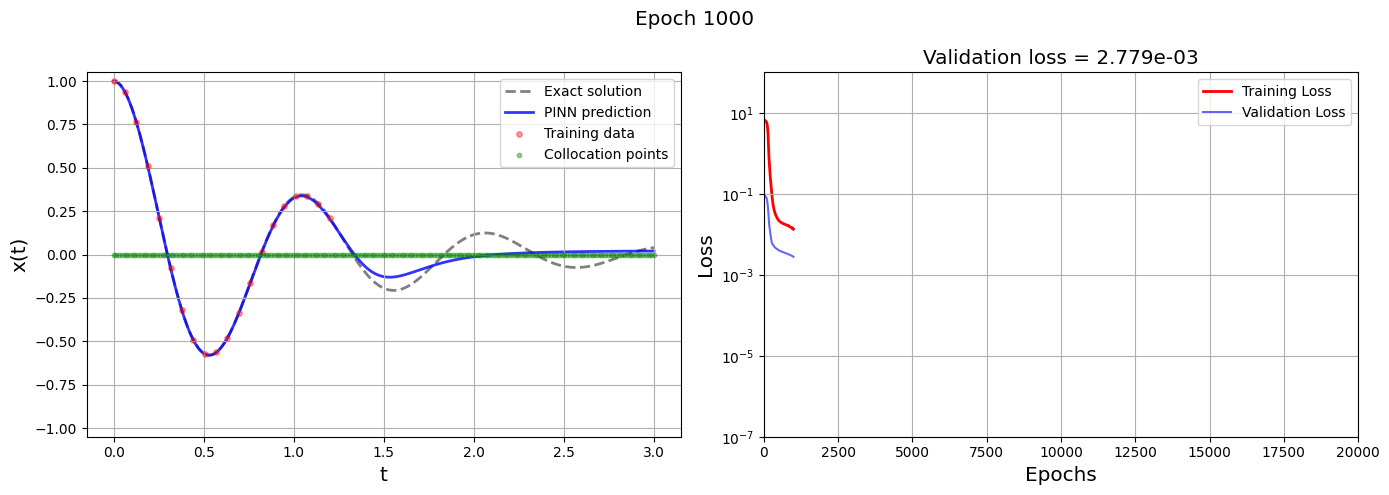

Epoch 1100: Validation Loss = 2.32852e-03, Learning rate = 7.2250e-04
Epoch 1200: Validation Loss = 1.55316e-03, Learning rate = 7.2250e-04
Epoch 1300: Validation Loss = 1.26596e-03, Learning rate = 7.2250e-04
Epoch 1400: Validation Loss = 1.19720e-03, Learning rate = 7.2250e-04
Epoch 1500: Validation Loss = 1.16324e-03, Learning rate = 7.2250e-04
Epoch 1600: Validation Loss = 1.20269e-03, Learning rate = 7.2250e-04
Epoch 1700: Validation Loss = 1.12192e-03, Learning rate = 7.2250e-04
Epoch 1800: Validation Loss = 1.11563e-03, Learning rate = 7.2250e-04
Epoch 1900: Validation Loss = 1.07932e-03, Learning rate = 7.2250e-04
Epoch 2000: Validation Loss = 1.05551e-03, Learning rate = 6.1412e-04
Epoch 2100: Validation Loss = 1.03085e-03, Learning rate = 6.1412e-04
Epoch 2200: Validation Loss = 1.00305e-03, Learning rate = 6.1412e-04
Epoch 2300: Validation Loss = 9.70102e-04, Learning rate = 6.1412e-04
Epoch 2400: Validation Loss = 9.30587e-04, Learning rate = 6.1412e-04
Epoch 2500: Validati

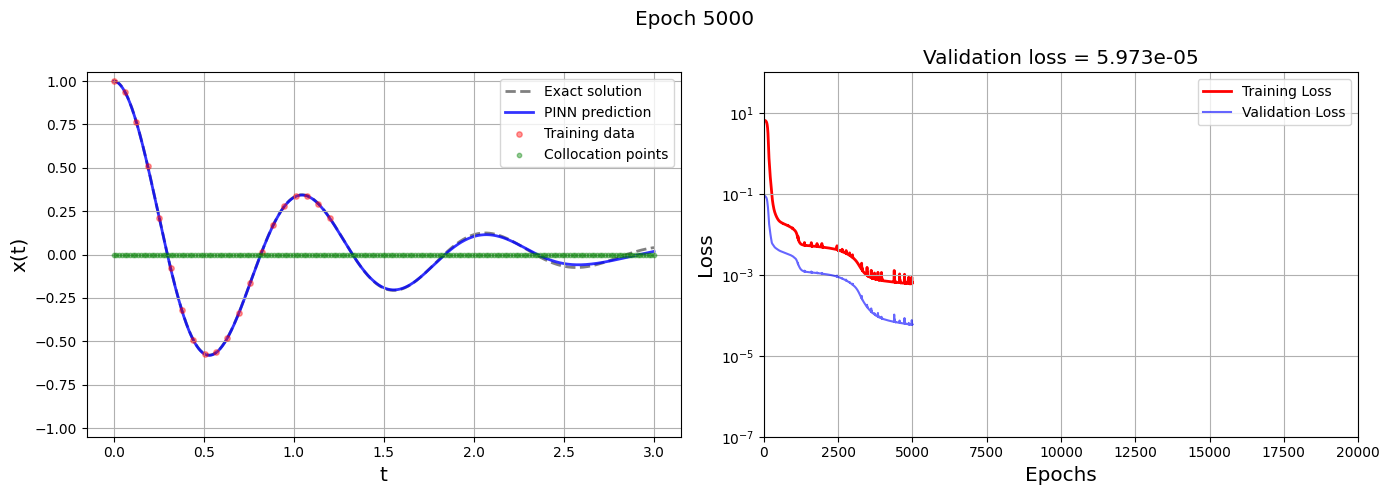

Epoch 5100: Validation Loss = 5.67194e-05, Learning rate = 3.7715e-04
Epoch 5200: Validation Loss = 5.54877e-05, Learning rate = 3.7715e-04
Epoch 5300: Validation Loss = 5.42563e-05, Learning rate = 3.7715e-04
Epoch 5400: Validation Loss = 5.30214e-05, Learning rate = 3.7715e-04
Epoch 5500: Validation Loss = 5.17260e-05, Learning rate = 3.7715e-04
Epoch 5600: Validation Loss = 5.05449e-05, Learning rate = 3.7715e-04
Epoch 5700: Validation Loss = 4.93084e-05, Learning rate = 3.7715e-04
Epoch 5800: Validation Loss = 4.80970e-05, Learning rate = 3.7715e-04
Epoch 5900: Validation Loss = 4.68426e-05, Learning rate = 3.7715e-04
Epoch 6000: Validation Loss = 4.56305e-05, Learning rate = 3.2058e-04
Epoch 6100: Validation Loss = 4.46564e-05, Learning rate = 3.2058e-04
Epoch 6200: Validation Loss = 4.36149e-05, Learning rate = 3.2058e-04
Epoch 6300: Validation Loss = 4.25580e-05, Learning rate = 3.2058e-04
Epoch 6400: Validation Loss = 4.14743e-05, Learning rate = 3.2058e-04
Epoch 6500: Validati

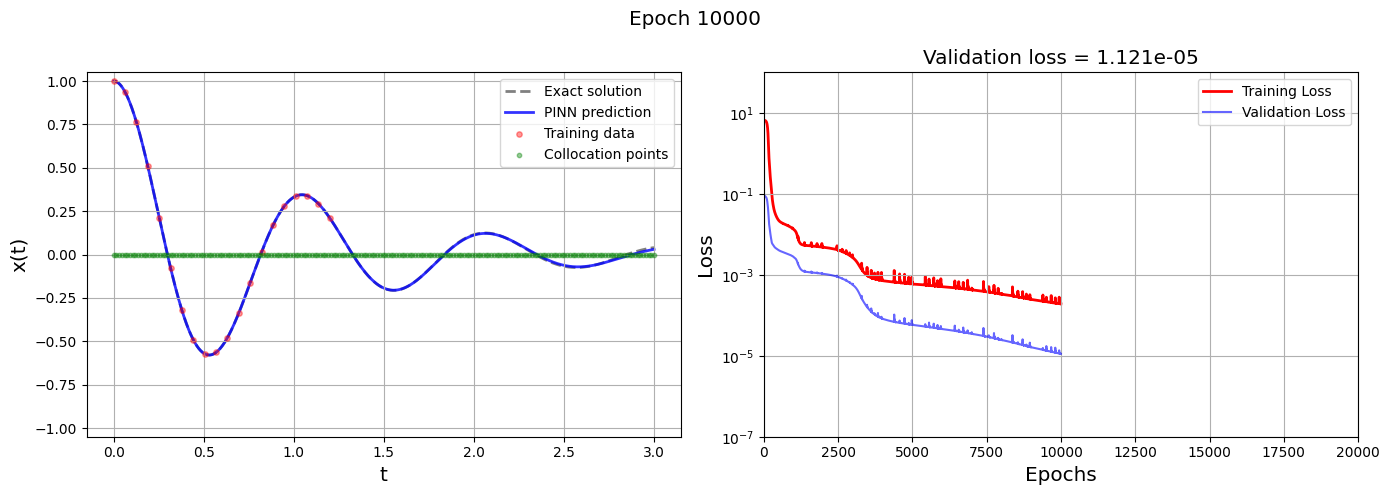

Epoch 10100: Validation Loss = 1.08689e-05, Learning rate = 1.6734e-04
Epoch 10200: Validation Loss = 1.05659e-05, Learning rate = 1.6734e-04
Epoch 10300: Validation Loss = 1.02765e-05, Learning rate = 1.6734e-04
Epoch 10400: Validation Loss = 9.99710e-06, Learning rate = 1.6734e-04
Epoch 10500: Validation Loss = 9.75039e-06, Learning rate = 1.6734e-04
Epoch 10600: Validation Loss = 9.47591e-06, Learning rate = 1.6734e-04
Epoch 10700: Validation Loss = 9.25583e-06, Learning rate = 1.6734e-04
Epoch 10800: Validation Loss = 9.02599e-06, Learning rate = 1.6734e-04
Epoch 10900: Validation Loss = 8.82529e-06, Learning rate = 1.6734e-04
Epoch 11000: Validation Loss = 8.61788e-06, Learning rate = 1.4224e-04
Epoch 11100: Validation Loss = 8.45991e-06, Learning rate = 1.4224e-04
Epoch 11200: Validation Loss = 8.30749e-06, Learning rate = 1.4224e-04
Epoch 11300: Validation Loss = 8.16171e-06, Learning rate = 1.4224e-04
Epoch 11400: Validation Loss = 8.02791e-06, Learning rate = 1.4224e-04
Epoch 

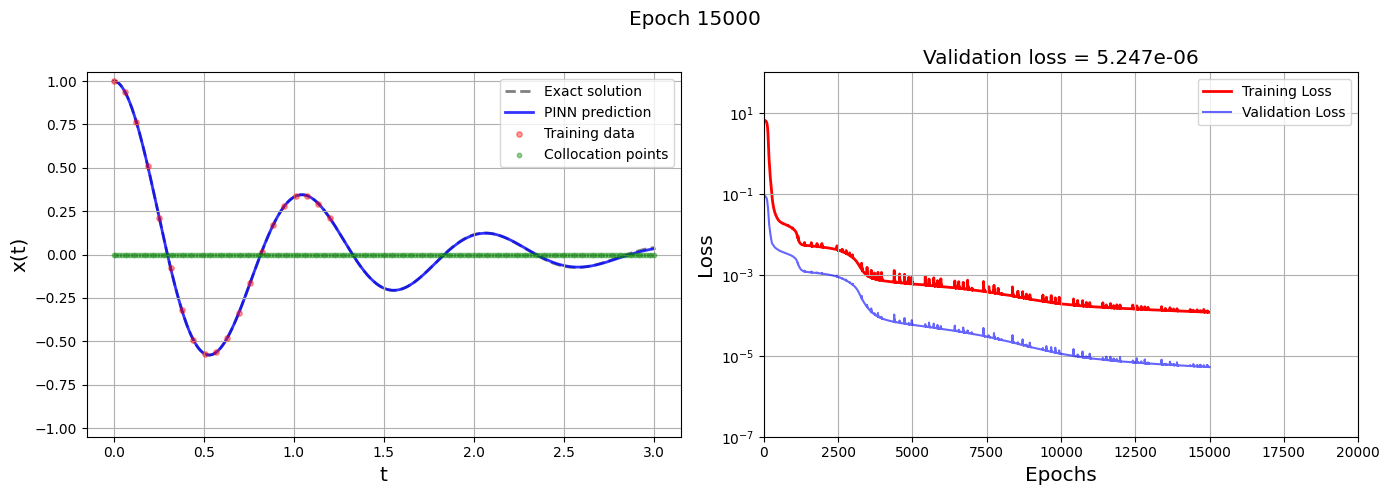

Epoch 15100: Validation Loss = 5.20216e-06, Learning rate = 7.4251e-05
Epoch 15200: Validation Loss = 5.15828e-06, Learning rate = 7.4251e-05
Epoch 15300: Validation Loss = 5.11311e-06, Learning rate = 7.4251e-05
Epoch 15400: Validation Loss = 5.12688e-06, Learning rate = 7.4251e-05
Epoch 15500: Validation Loss = 5.02158e-06, Learning rate = 7.4251e-05
Epoch 15600: Validation Loss = 4.98126e-06, Learning rate = 7.4251e-05
Epoch 15700: Validation Loss = 4.93931e-06, Learning rate = 7.4251e-05
Epoch 15800: Validation Loss = 4.94725e-06, Learning rate = 7.4251e-05
Epoch 15900: Validation Loss = 4.87422e-06, Learning rate = 7.4251e-05
Epoch 16000: Validation Loss = 4.82087e-06, Learning rate = 6.3113e-05
Epoch 16100: Validation Loss = 4.75912e-06, Learning rate = 6.3113e-05
Epoch 16200: Validation Loss = 4.71981e-06, Learning rate = 6.3113e-05
Epoch 16300: Validation Loss = 4.67958e-06, Learning rate = 6.3113e-05
Epoch 16400: Validation Loss = 4.75106e-06, Learning rate = 6.3113e-05
Epoch 

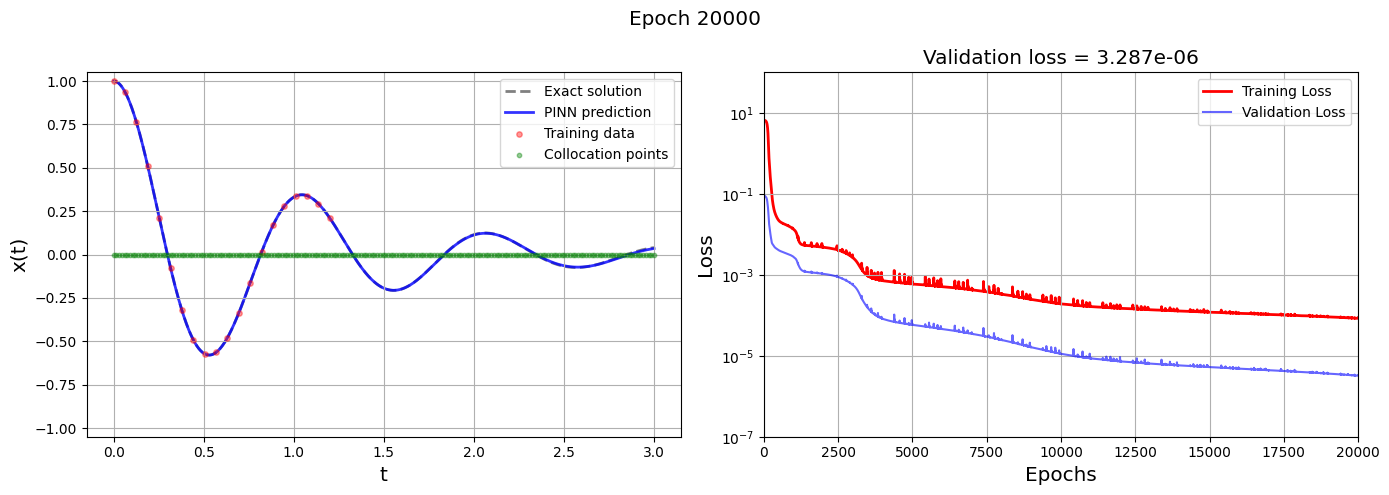

In [81]:
# PINN
PINN = FCN(1, 1, N_nodes, N_layers)

# Uses the Adam optimizer
optimizer = torch.optim.Adam(PINN.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

# Number of training steps
training_loss_history   = []
validation_loss_history = []

for i in range(epochs):
    # ===
    # Training
    # ===
    
    PINN.train()
    optimizer.zero_grad()
    
    # Compute data and derivative loss .........................
    u  = PINN(t_training)
    du = torch.autograd.grad(u, t_training, torch.ones_like(u), create_graph=True)[0]
    
    data_loss       = torch.mean((u  - x1_data)**2)
    derivative_loss = torch.mean((du - x2_data)**2)
    
    # Compute the ODE loss .........................
    
    z   = PINN(t_physics)
    dz  = torch.autograd.grad(z, t_physics, torch.ones_like(z), create_graph=True)[0]
    d2z = torch.autograd.grad(dz, t_physics, torch.ones_like(dz), create_graph=True)[0]
    ode = d2z - F(z, dz, t_physics, (w0, b))
    ode_loss = torch.mean(ode**2)
    
    # Compute total loss
    loss = weights[0]*data_loss + weights[1]*derivative_loss + weights[2]*ode_loss
    
    # Backpropagate the loss and update weights
    loss.backward()
    optimizer.step()
    if i%1000 == 0:
        scheduler.step()
    
    # ===
    # Validation
    # ===
    PINN.eval()

    v = PINN(t_validation)
    data_loss_val       = torch.mean((v - x1_val)**2)
    loss_val = data_loss_val
    
    # ===
    # Saving training information
    # ===
    p = PINN(t).detach()
    
    training_loss_history.append(loss.item())
    validation_loss_history.append(loss_val.item())
    
    # ===
    # Plotting
    # ===
    if (i % 100) == 0:
        print(f"Epoch {i}: Validation Loss = {loss_val.item():.5e}, Learning rate = {optimizer.param_groups[0]['lr']:.4e}")
        if any([i==epochs-1, i%5000==0, i==1000]):
            plot_result()
            plt.show()